# Manga Translator

[google colab](https://colab.research.google.com/drive/1fd25SZuMsUeWund6Sy5yarhj6c4UJL7z?usp=sharing)

## Load Library

In [ ]:
%%capture
!pip install ultralytics
!pip install split-folders
!pip install transformers
!pip install -Uq gdown
!pip install natsort
!pip install sentencepiece

#restart runtime
import os
os.kill(os.getpid(), 9)

## Library

In [4]:
import os
from glob import glob
from tqdm import tqdm

#image
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

import matplotlib.pyplot as plt

import splitfolders
from natsort import natsorted

#YOLO
import splitfolders
from ultralytics import YOLO

#ocr
from transformers import AutoTokenizer, AutoModel
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

## Load Data
data for train yolo

In [ ]:
!gdown 1VyRACCm-hp55Vnungc6LDWLUyMBnmjMR

Downloading...
From (uriginal): https://drive.google.com/uc?id=1VyRACCm-hp55Vnungc6LDWLUyMBnmjMR
From (redirected): https://drive.google.com/uc?id=1VyRACCm-hp55Vnungc6LDWLUyMBnmjMR&confirm=t&uuid=7cdfcbfd-758f-444c-86d0-5d9c32371340
To: /content/Data.tar.gz
100% 259M/259M [00:05<00:00, 48.3MB/s]


In [ ]:
%%capture
!rm -rf yolo
!mkdir yolo
!tar -xzvf /content/Data.tar.gz -C yolo     #[run this cell to extract tar.gz files]

## Yolov8

finetune for detect text

### data format

In [ ]:
os.rename('/content/yolo/ground_truth', '/content/yolo/labels')

In [ ]:
lis = glob('/content/yolo/labels/*.txt')
for src in tqdm(lis):
  des = src.replace('gt_', '')

  os.rename(src, des)

100%|██████████| 461/461 [00:00<00:00, 41788.03it/s]


In [ ]:
lis = glob('/content/yolo/labels/*.txt')
for txt_path in tqdm(lis):

  #img
  img_path = txt_path.replace('labels', 'images').replace('txt', 'jpg')
  img = cv2.imread(img_path)

  #image width, image height
  img_h, img_w, _ = img.shape

  
  txt_save = ''
  #open txt file to get label and change to yolo
  txt = open(txt_path).read()
  x_y = txt.split('\n')
  for i in x_y[:-1]:
    x1, y1, x2, y2 = i.split()[:-1]
    x1, y1, x2, y2 = float(x1.replace(',', '')), float(y1.replace(',', '')), float(x2.replace(',', '')), float(y2.replace(',', ''))

    w = x2-x1
    h = y2-y1

    # Finding midpoints
    x_centre = (x1 + (x1+w))/2
    y_centre = (y1 + (y1+h))/2

    # Normalization
    x_centre = x_centre / img_w
    y_centre = y_centre / img_h
    w = w / img_w
    h = h / img_h

    # Limiting upto fix number of decimal places
    x_centre = format(x_centre, '.6f')
    y_centre = format(y_centre, '.6f')
    w = format(w, '.6f')
    h = format(h, '.6f')

    txt_save += f'0 {x_centre} {y_centre} {w} {h}\n'
  
  #save text file
  os.remove(txt_path)
  f = open(txt_path, "a")
  f.write(txt_save)
  f.close()

100%|██████████| 461/461 [00:14<00:00, 32.35it/s]


### Split folder

to train and validation

In [ ]:
#split train : validate data
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!rm -rf /content/yolo_split

splitfolders.ratio("./yolo", output="./yolo_split",
    seed=0, ratio=(.9, .1), group_prefix=None, move=False) # default values

Copying files: 922 files [00:00, 935.68 files/s]


### yaml

for yolo annotation

** dont forget to run

In [ ]:
%%file data.yaml
path: ../yolo_split  # dataset root dir
train: train/images  # train images (relative to 'path') 
val: val/images  # val images (relative to 'path') 
# test:  # test images (optional)

# Classes #default 80 classes COCO dataset 

names:
  0: 'text'

Writing data.yaml


### Train

In [ ]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 165MB/s]


In [ ]:
!rm -rf '/content/yolo_model'
model.train(data='data.yaml', epochs=120, imgsz = 640, optimizer='SGD', project = 'yolo_model')

Ultralytics YOLOv8.0.61 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=120, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_model, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify

RuntimeError: ignored

In [ ]:
#save model to drive
!zip -r -q 'yolo_best.zip' './yolo_model/train/weights/best.pt'
!cp -r 'yolo_best.zip' '/content/drive/MyDrive/Colab Notebooks/GitRepo/Manga Translator/yolo model'

## Find Text box in image

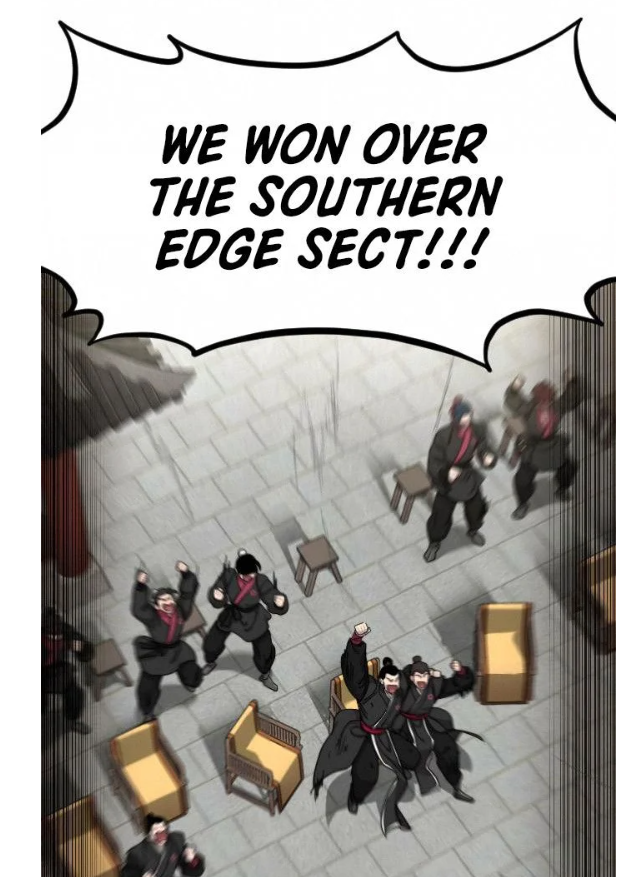

In [65]:
img_path_ocr = 'ocr5.png'
img = cv2.imread(img_path_ocr)
cv2_imshow(img)

In [6]:
# #load yolov8 that finetune for text detection
# !gdown 1wbF4MQq39lne8139i9Z6R_BbMgtiBpF-
# !unzip -q yolo_best.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1wbF4MQq39lne8139i9Z6R_BbMgtiBpF-
From (redirected): https://drive.google.com/uc?id=1wbF4MQq39lne8139i9Z6R_BbMgtiBpF-&confirm=t&uuid=e90fbece-faa4-4d85-9786-6ff33cc12c20
To: /content/yolo_best.zip
100% 82.9M/82.9M [00:01<00:00, 68.4MB/s]


In [66]:
model = YOLO('/content/yolo_model/train/weights/best.pt')
save_predict = 'predict_detect'
!rm -rf $save_predict
res_pred = model(img_path_ocr, save_txt=True, save_crop=True, project=save_predict, exist_ok=False, save=True, save_conf=False, conf = 0.70)


image 1/1 /content/ocr5.png: 640x480 7 texts, 86.7ms
Speed: 0.6ms preprocess, 86.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to predict_detect/predict
1 label saved to predict_detect/predict/labels


In [67]:
def yl2xy(lis, image_width, image_height):

  cls, center_X, center_y, width, height = lis
  cls, center_X, center_y, width, height = float(cls), float(center_X), float(center_y), float(width), float(height)

  x1 = (center_X-width/2)*image_width
  x2 = (center_X+width/2)*image_width
  y1 = (center_y-height/2)*image_height
  y2 = (center_y+height/2)*image_height

  # Limiting upto fix number of decimal places
  x1 = format(x1, '.3f')
  y1 = format(y1, '.3f')
  x2 = format(x2, '.3f')
  y2 = format(y2, '.3f')

  return float(x1), float(y1), float(x2), float(y2)

In [68]:
#image
img_path = glob('/content/predict_detect/predict/*.png')
img = cv2.imread(img_path[0])
img_h, img_w, _ = img.shape

#label
label_path = glob('/content/predict_detect/predict/labels/*.txt')
txt = open(label_path[0]).read()
txt = txt.split('\n')

#get x y
objects = list()
x_y = []
dic = dict()
for i in txt[:-1]:
  lis = i.split()
  x1, y1, x2, y2 = yl2xy(lis, img_w, img_h)
  x_y.append([x1, y1, x2, y2])

  #add x1, y1 for sort object
  objects.append((x1, y1))

#ทำให้ค่า y ที่มีค่าใกล้เคียงกันเท่ากัน
y = []
for i in objects:
  y.append(i[1])

for i in range(len(y)):
  check = y[i]

  for j in range(len(y)):
    check2 = y[j]

    if abs(check-check2) < 2:
      y[j] = int(check)

objects_sort= []
for i in range(len(objects)):
  value = list(objects[i])
  value[1] = y[i]
  objects_sort.append(tuple(value))


#add value to dict
for i in range(len(objects_sort)):
  key = objects_sort[i]
  value = x_y[i]
  dic.update({key: value})


#sort text from top left to bottom right
sorted_objects = sorted(objects_sort, key=lambda obj: (obj[1], obj[0]))

print(sorted_objects)

[(161.179, 121), (246.525, 121), (361.665, 121), (150.731, 176), (249.342, 176), (155.745, 226), (298.355, 226)]


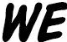

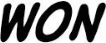

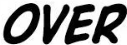

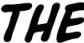

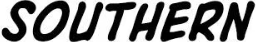

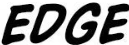

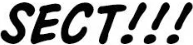

In [69]:
#ruturn sort image
img = cv2.imread(img_path_ocr)
crop = []
for key in sorted_objects:
  x1, y1, x2, y2 = dic[key]
  x1, y1, x2, y2 = int(x1)-1, int(y1)-1, int(x2)+1, int(y2)+1
  img_crop = img[y1:y2, x1:x2].copy()
  crop.append(img_crop)

!rm -rf ocr_job
!mkdir ocr_job
for idx, i in enumerate(crop):
  cv2_imshow(i)
  save_path = f'ocr_job/{idx}.jpg'
  cv2.imwrite(save_path, i)

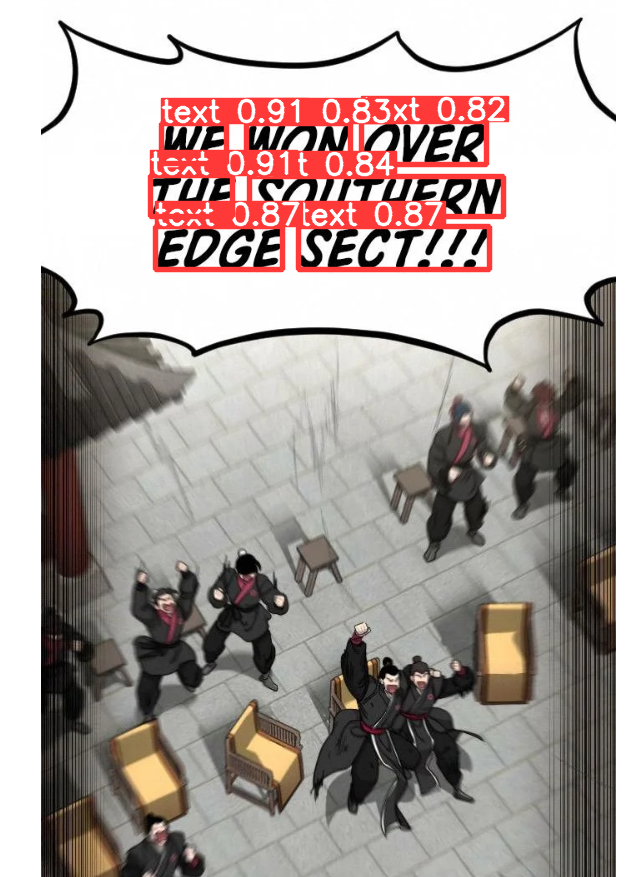

In [70]:
img_path = glob('/content/predict_detect/predict/*.png')
img = cv2.imread(img_path[0])
cv2_imshow(img)

## OCR

In [71]:
%%capture
name = 'microsoft/trocr-small-printed'
# name = 'microsoft/trocr-large-handwritten'
processor = TrOCRProcessor.from_pretrained(name)
model = VisionEncoderDecoderModel.from_pretrained(name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# load image from the IAM database (actually this model is meant to be used on printed text)
def ocr(img_path):
  image = Image.open(img_path).convert("RGB")

  pixel_values = processor(images=image, return_tensors="pt").pixel_values

  generated_ids = model.generate(pixel_values)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_text

In [73]:
img_path = natsorted(glob('/content/ocr_job/*.jpg'))
final_txt = ''
for i in img_path:
  txt = ocr(i)
  print(txt)
  final_txt += txt + ' '
final_txt = final_txt.strip()
final_txt

WE
WON
OVER
THE
SOUTHERN
EDGE
SECT!!!


'WE WON OVER THE SOUTHERN EDGE SECT!!!'

In [74]:
final_txt = final_txt.strip()
final_txt

'WE WON OVER THE SOUTHERN EDGE SECT!!!'

## Translate

In [86]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
name = "facebook/m2m100_418M"
model = M2M100ForConditionalGeneration.from_pretrained(name)
tokenizer = M2M100Tokenizer.from_pretrained(name)

# translate en to th
tokenizer.src_lang = "en"
encoded_en = tokenizer(final_txt, return_tensors="pt")
generated_tokens = model.generate(**encoded_en, forced_bos_token_id=tokenizer.get_lang_id("th"))
tran_txt = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
tran_txt

['เราอยู่เหนือภาคตะวันออก!!!']

## Warp text eng to thai

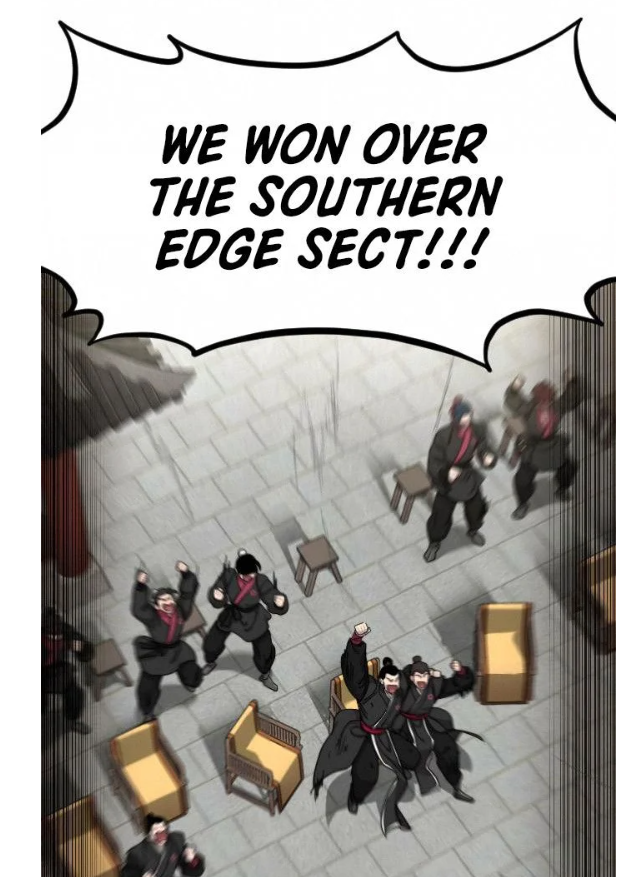

In [77]:
img = cv2.imread(img_path_ocr)
cv2_imshow(img)